# Project Milestone Two: Modeling and Feature Engineering

### Due: Midnight on April 13 (with 2-hour grace period) and worth 25 points

### Overview

This milestone builds on your work from Milestone 1. You will:

1. Evaluate baseline models using default settings.
2. Engineer new features and re-evaluate models.
3. Use feature selection techniques to find promising subsets.
4. Select the top 3 models and fine-tune them for optimal performance.

You must do all work in this notebook and upload to your team leader's account in Gradescope. There is no
Individual Assessment for this Milestone. 


In [1]:
# ===================================
# Useful Imports: Add more as needed
# ===================================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars
import seaborn as sns

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Progress Tracking

from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Load your Preprocessed Dataset from Milestone 1

In Milestone 1, you handled missing values, encoded categorical features, and explored your data. Before you begin this milestone, you’ll need to load that cleaned dataset and prepare it for modeling.

Here’s what to do:

1. Return to your Milestone 1 notebook and rerun your code through Part 3, where your dataset was fully cleaned (assume it’s called `df_cleaned`).

2. **Save** the cleaned dataset to a file by running:

>   df_cleaned.to_csv("zillow_cleaned.csv", index=False)

3. Switch to this notebook and **load** the saved data:

>   df = pd.read_csv("zillow_cleaned.csv")

4. Create a **train/test split** using `train_test_split`.  
   
6. **Standardize** the features (but not the target!) using **only the training data.** This ensures consistency across models without introducing data leakage from the test set:

>   scaler = StandardScaler()   
>   X_train_scaled = scaler.fit_transform(X_train)    
  
**Notes:** 

- You will not use the testing set during this milestone — it’s reserved for final evaluation later.
- You will have to redo the scaling step when you introduce new features (which have to be scaled as well).


In [2]:
# Create a function for reading the dataset and splitting into training and testing sets with scaled and unscaled data
def load_data(path):
    df = pd.read_csv(path)
    # check if the dataset has been loaded properly
    if df.empty:
        raise ValueError("the dataset is empty, please check the path or the file content.")
    print(f"loaded dataset with shape: {df.shape}")

    # Split the data into features and target variables
    X = df.drop(columns=['taxvaluedollarcnt'])
    y = df['taxvaluedollarcnt']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state
    )

    # create scaled versions of the train and test features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)

    # add feature names to the scaled data
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

    return X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, df, X, y

In [3]:
X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, df, X, y = load_data('Milestone Data/zillow_cleaned.csv')

loaded dataset with shape: (71217, 25)


### Part 1: Baseline Modeling [3 pts]

Apply the following regression models to the scaled training dataset using **default parameters**:

- Linear Regression
- Ridge Regression
- Lasso Regression
- Decision Tree Regression
- Bagging
- Random Forest
- Gradient Boosting Trees

For each model:
- Use **repeated cross-validation** (e.g., 5 folds, 5 repeats).
- Report the **mean and standard deviation of CV RMSE Score** across all folds in a table. 


In [ ]:
def run_model(model, x_train, y_train, x_test=None, y_test=None, test=False, n_repeats=5, n_jobs=-1, random_state=random_state, **model_params):

    # Instantiate the model if a class is provided, so for example can use either BaggingRegressor or BaggingRegressor() as argument. 
    if isinstance(model, type):
        model = model(**model_params)

    neg_rmse_scores = cross_val_score(model, x_train, y_train, scoring = 'neg_root_mean_squared_error',
                                     cv = RepeatedKFold(n_splits=5, n_repeats=n_repeats, random_state=random_state), n_jobs = n_jobs)
    
    mean_cv_rmse = -np.mean(neg_rmse_scores)
    std_cv_rmse  = np.std(neg_rmse_scores)
    
    # Fit the model on the full training set
    model.fit(x_train, y_train)
    
    # Compute training RMSE
    if test:
        train_preds = model.predict(x_train)
        train_rmse = root_mean_squared_error(y_train, train_preds)
        test_preds = model.predict(x_test)
        test_rmse = root_mean_squared_error(y_test, test_preds)
    
        return mean_cv_rmse, std_cv_rmse, train_rmse, test_rmse
    
    else:
        train_preds = model.predict(x_train)
        train_rmse = root_mean_squared_error(y_train, train_preds)

        return mean_cv_rmse, std_cv_rmse, train_rmse

In [5]:
model_dict = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Bagging": BaggingRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
    }

In [6]:
def evaluate_model(
    models, 
    x_train, y_train, 
    x_test=None, y_test=None, 
    evaluate=False, 
    random_state=random_state, 
    **model_params
):

    results = {}

    for name, model in models.items():
        print(f"Evaluating {name}…")

        if evaluate:
            # run_model must accept x_test, y_test, test=True
            mean_cv_rmse, std_cv_rmse, train_rmse, test_rmse = run_model(
                model,
                x_train, y_train,
                x_test, y_test,
                test=True,
                random_state=random_state,
                **model_params
            )
        else:
            # only get the three training‐set metrics
            mean_cv_rmse, std_cv_rmse, train_rmse = run_model(
                model,
                x_train, y_train,
                x_test=None, y_test=None,
                test=False,
                random_state=random_state,
                **model_params
            )
            test_rmse = None

        # now format only the things you actually have
        row = {
            'Mean CV RMSE': dollar_format(mean_cv_rmse, 2),
            'STD CV RMSE' : dollar_format(std_cv_rmse, 2),
            'Train RMSE': dollar_format(train_rmse, 2),
        }
        if evaluate:
            # guard against a still‐None test_rmse
            row['Test RMSE'] = dollar_format(test_rmse, 2) if test_rmse is not None else "N/A"

        results[name] = row

    df = pd.DataFrame(results).T
    df.index.name = 'Model'
    sort_col = 'Test RMSE' if evaluate else 'Mean CV RMSE'
    return df.sort_values(by=sort_col)


In [7]:
raw_features = evaluate_model(model_dict, x_train=X_train_scaled, y_train=y_train, random_state=random_state)
print("================================")
raw_features

Evaluating Linear…
Evaluating Ridge…
Evaluating Lasso…
Evaluating Decision Tree…
Evaluating Bagging…
Evaluating Random Forest…
Evaluating Gradient Boosting…


,Mean CV RMSE,STD CV RMSE,Train RMSE
Model,,,
Random Forest,"$241,667","$2,300","$92,048"
Gradient Boosting,"$245,816","$2,741","$242,356"
Bagging,"$251,624","$2,464","$106,598"
Linear,"$276,212","$2,985","$276,019"
Ridge,"$276,212","$2,985","$276,019"
Lasso,"$276,212","$2,985","$276,019"
Decision Tree,"$333,336","$3,663","$24,216"


### Part 1: Discussion [2 pts]

In a paragraph or well-organized set of bullet points, briefly compare and discuss:

  - Which models perform best overall?
  - Which are most stable (lowest std)?
  - Any signs of overfitting or underfitting?

** Answers **
* The top 3 best performing models were the Random Forest, Gradient Boosting, and Bagging tree models. Random Forest was best overall with top 2 marks in all measurements with the best Mean CV RMSE of $241,624 
* The top 3 most stable models are the same top 3 performers, Bagging, Random Forest, Gradient Boosting. Bagging was the most stable with a standard deviation of $2,394
* The Decision Tree regressor might have been subject to overfitting as it's training rmse was very low, almost to the point of an optimized model, and it's Mean CV RMSE was very high compared to the rest. The Linear, Ridge, and Lasso models seemed to underfit the model because their training rmse values were almost identical to their Mean CV rmse scores.

### Part 2: Feature Engineering [3 pts]

Consider **at least three new features** based on your Milestone 1, Part 5. Examples include:
- Polynomial terms
- Log or interaction terms
- Groupings or transformations of categorical features

Add these features to `X_train` and then:
- Scale using `StandardScaler` 
- Re-run all models listed above (using default settings again).
- Report updated RMSE scores (mean and std) across repeated CV in a table. 

**Note:**  Recall that this will require creating a new version of the dataset, so effectively you may be running "polynomial regression" using `LinearRegression`. 

In [8]:
# Standard Scaler for large variance numberic features
def standardized(df, column):
  scaler = StandardScaler()
  fig, axes = plt.subplots(1,2, figsize=(10,6))
  axes[0].boxplot(df[column])
  axes[0].set_title(column)
  df[f'{column}'] = scaler.fit_transform(df[[column]])
  axes[1].boxplot(df[f'{column}'])
  axes[1].set_title(f'standardized {column}')

In [9]:
# log transfer
def log_transformation(df, column):
  fig, axes = plt.subplots(1, 2, figsize=(10,6))
  axes[0].boxplot(df[column])
  axes[0].set_title(column)
  df[f'{column}'] = np.log(df[column])
  axes[1].boxplot(df[f'{column}'])
  axes[1].set_title(f'log transformed {column}')

In [10]:
# polynomial for calculatedbathnbr
def polynomial_transformation(df, column, degree):
  fig, axes = plt.subplots(1, 2, figsize=(10,6))
  axes[0].boxplot(df[column])
  axes[0].set_title(column)
  df[f'{column}'] = df[column]**degree
  axes[1].boxplot(df[f'{column}'])
  axes[1].set_title(f'poly transformed {column}')

In [11]:
pd.set_option('display.max_columns', None)
df_transformations = df.copy()
df_transformations.head()

,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fireplacecnt,fullbathcnt,garagecarcnt,garageunknown,hashottuborspa,heatingorsystemtypeid,lotsizesquarefeet,poolcnt,propertylandusetypeid,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,unitcnt,yearbuilt,taxdelinquencyflag,taxvaluedollarcnt
0,0.0,3.5,4.0,8.0,3.5,3100.0,3100.0,0.0,3.0,2.0,0,False,2.0,4506.0,0.0,261.0,53571.0,1286.0,48570.0,96978.0,0.0,0.0,1998.0,False,1023282.0
1,0.0,1.0,2.0,8.0,1.0,1465.0,1465.0,1.0,1.0,1.0,0,False,2.0,12647.0,0.0,261.0,13091.0,2061.0,48570.0,97099.0,5.0,0.0,1967.0,False,464000.0
2,0.0,2.0,3.0,8.0,2.0,1243.0,1243.0,0.0,2.0,2.0,0,False,2.0,8432.0,1.0,261.0,21412.0,1286.0,48570.0,97078.0,6.0,0.0,1962.0,False,564778.0
3,0.0,3.0,4.0,8.0,3.0,2376.0,2376.0,0.0,3.0,0.0,1,False,2.0,13038.0,1.0,261.0,396551.0,3101.0,48570.0,96330.0,0.0,1.0,1970.0,False,145143.0
4,0.0,3.0,3.0,8.0,3.0,1312.0,1312.0,0.0,3.0,0.0,1,False,2.0,278581.0,1.0,266.0,12447.0,3101.0,268548.0,96451.0,0.0,1.0,1964.0,False,119407.0


In [12]:
# Split the df_transofrmation data into features and target variables
X_t = df_transformations.drop(columns=['taxvaluedollarcnt'])
y_t = df_transformations['taxvaluedollarcnt']

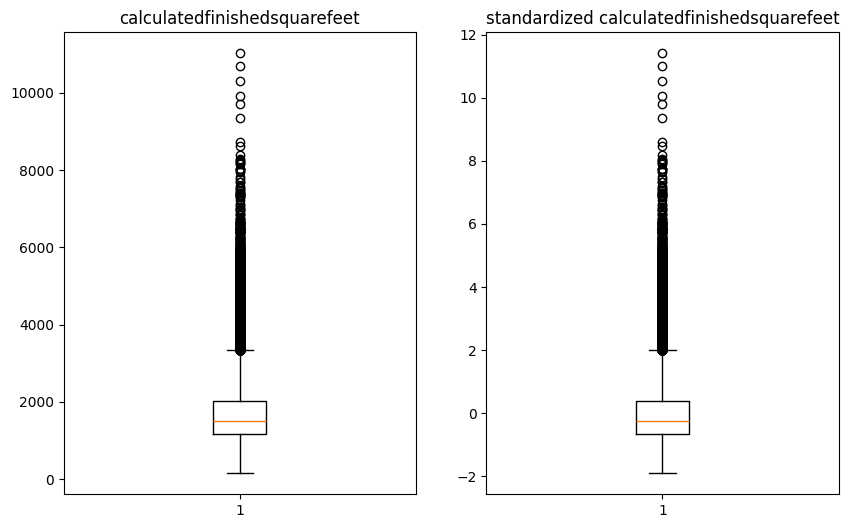

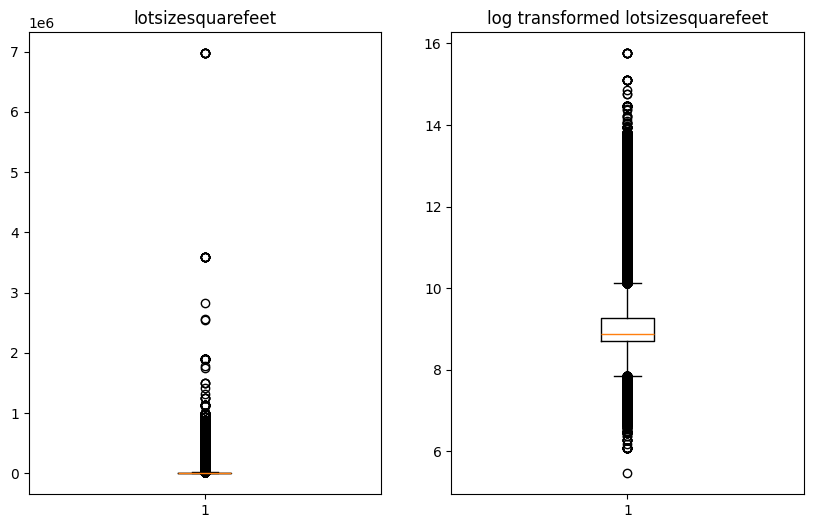

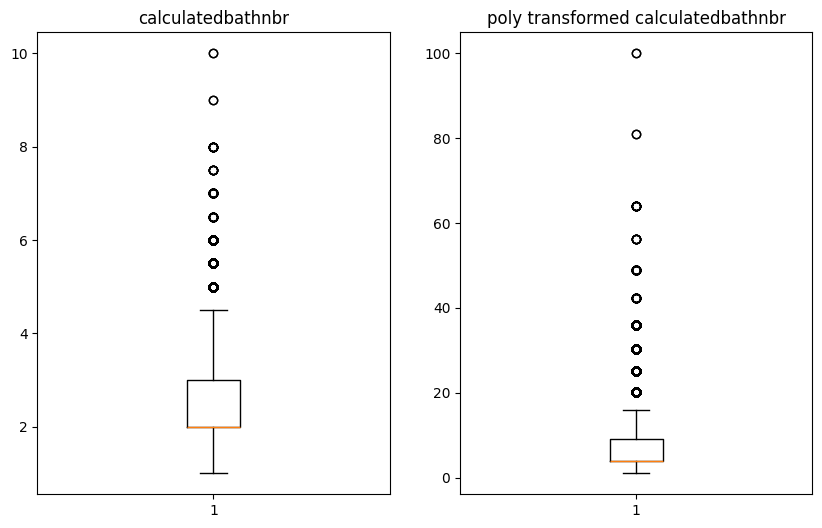

In [13]:
# transform features using the defined funcitons
standardized(X_t, 'calculatedfinishedsquarefeet')

log_transformation(X_t, 'lotsizesquarefeet')

polynomial_transformation(X_t, 'calculatedbathnbr', 2)

In [14]:
# Standardize the transformed features and split into training and testing sets
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(
    X_t, y_t, test_size=.2, random_state=random_state
)

scaler_t = StandardScaler()
X_train_scaled_t = scaler_t.fit_transform(X_train_t)
X_test_scaled_t = scaler_t.fit_transform(X_test_t)

X_train_scaled_t = pd.DataFrame(X_train_scaled_t, columns=X_t.columns)
X_test_scaled_t = pd.DataFrame(X_test_scaled_t, columns=X_t.columns)

In [15]:
# Evaluate the models again with the transformed features
transformed_features = evaluate_model(model_dict, x_train=X_train_scaled_t, y_train=y_train_t, random_state=random_state)
print("================================")
transformed_features

Evaluating Linear…
Evaluating Ridge…
Evaluating Lasso…
Evaluating Decision Tree…
Evaluating Bagging…
Evaluating Random Forest…
Evaluating Gradient Boosting…


,Mean CV RMSE,STD CV RMSE,Train RMSE
Model,,,
Random Forest,"$241,676","$2,421","$92,120"
Gradient Boosting,"$245,813","$2,738","$242,356"
Bagging,"$251,738","$2,714","$107,243"
Linear,"$275,450","$2,983","$275,214"
Ridge,"$275,450","$2,983","$275,214"
Lasso,"$275,450","$2,983","$275,214"
Decision Tree,"$332,968","$3,203","$24,216"


In [16]:
raw_features

,Mean CV RMSE,STD CV RMSE,Train RMSE
Model,,,
Random Forest,"$241,667","$2,300","$92,048"
Gradient Boosting,"$245,816","$2,741","$242,356"
Bagging,"$251,624","$2,464","$106,598"
Linear,"$276,212","$2,985","$276,019"
Ridge,"$276,212","$2,985","$276,019"
Lasso,"$276,212","$2,985","$276,019"
Decision Tree,"$333,336","$3,663","$24,216"


### Part 2: Discussion [2 pts]

Reflect on the impact of your new features:

- Did any models show notable improvement in performance?

- Which new features seemed to help — and in which models?

- Do you have any hypotheses about why a particular feature helped (or didn’t)?

- Were there any unexpected results?



** Answers **
* No noticeable improvements were made when evaluating models with transformed features, in some cases, models regressed in performance. The Random Forest model which performed the best in all categories had a worse standard deviation after being evaluated on the transformed df.
* Standardizing and Log transforming features seem to have very small improvements no matter the feature. However, Polynomial transformations didn't seem to imporve the forformance of the models/were not affected by the transformation.
* Tree models are relativeley unaffected by scaling features since they preserve the underlying relationship to the target. Since the 3 ensemble models we are evaluating on are tree based they showed little improvement
* The results were somewhat surprising as I was expecting more than negligible differences between the raw vs transformed features.

### Part 3: Feature Selection [3 pts]

Using the full set of features (original + engineered):
- Apply **feature selection** methods to investigate whether you can improve performance.
  - You may use forward selection, backward selection, or feature importance from tree-based models.
- For each model, identify the **best-performing subset of features**.
- Re-run each model using only those features.
- Report updated RMSE scores (mean and std) across repeated CV in a table.


In [17]:
# Backward Feature Selection
def backward_feature_selection(X, y, model,
                               scoring='neg_root_mean_squared_error',
                               cv=5,
                               tol=None,               # None = no delta cutoff
                                                       # use 0.0 for "no further improvements"
                                                       # and 1e-4 for "point of diminishing returns"
                               max_features=None,      # If None, remove features until only 1 remains
                                                       # Otherwise, stop when this many features remain
                               n_jobs=-1,
                               verbose=False
                              ):

    # Helper function to compute CV score using LinearRegression
    def cv_score(features):
        return -cross_val_score(model, X[features], y,
                                scoring=scoring, cv=cv,
                                n_jobs=n_jobs          ).mean()

    # Start with all features (using a list for easier manipulation)
    features_remaining = list(X.columns)

    # Compute initial CV score with the full feature set
    initial_score = cv_score(features_remaining)

    # Initialize tracking variables
    best_score        = initial_score                # Best (lowest) CV score observed so far
    best_feature_set  = features_remaining.copy()    # Feature set corresponding to best_score
    selected_features = ['NONE']                     # List to record the order in which features are removed
    best_scores       = [initial_score]              # List to record the CV score after each removal (starting with full set)

    if verbose:
        print("Start with full set of features:")
        print(f'{features_remaining}  CV score (MSE): {np.around(initial_score, 4)}\n')

    # Determine the target number of features to keep:
    # For backward elimination, if max_features is None, we remove until 1 feature remains.
    target_feature_count = 1 if max_features is None else max_features

    prev_score = initial_score
    round_num = 1
    # Continue removing features until we reach the target count
    while len(features_remaining) > target_feature_count:
        if verbose:
            print(f'Round {round_num}:')

        # Initialize variables to track the best removal in this round
        lowest_score = float('inf')
        feature_to_remove = None
        best_new_features = None

        # Try removing each feature one at a time
        for feature in features_remaining:
            new_feature_set = features_remaining.copy()
            new_feature_set.remove(feature)
            new_score = cv_score(new_feature_set)
            if verbose:
                print('Trying removal of:',feature, np.around(new_score, 4))
            if new_score < lowest_score:
                lowest_score = new_score
                feature_to_remove = feature
                best_new_features = new_feature_set

        # Check if improvement is significant enough (if tol is set)
        if tol is not None and (prev_score - lowest_score) < tol:
            if verbose:
                print("\nStopping early due to minimal improvement.")
            break

        # Update the best score and feature set if current removal improves performance
        if lowest_score < best_score:
            best_score = lowest_score
            best_feature_set = best_new_features.copy()

        # Update trackers for this round
        prev_score = lowest_score
        features_remaining = best_new_features
        selected_features.append(feature_to_remove)
        best_scores.append(lowest_score)

        if verbose:
            print(f'\nRemoving {feature_to_remove}:  CV score (MSE) {np.around(lowest_score, 4)}\n')
        round_num += 1

    return (
        selected_features,      # Order in which features were removed
        best_scores,            # CV scores after each removal step
        best_feature_set,       # Feature set that achieved the best CV score
        best_score              # Best (lowest) CV score
    )


In [38]:
# Regular models
model_reg = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Bagging": BaggingRegressor()
    }

# Tree models
model_importance = {
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
    } 

In [19]:
from sklearn.base import clone

# forward and backward feature selection for regular models
def apply_best_feats_to_regular_models(dict, selection, random_state=random_state):
    best_results = {}

    for model_name, model in dict.items():

        print(f"Evaluating {model_name}...")

        # Cloning model for selection 
        model_for_search = clone(model)
        model_for_eval = clone(model)

        selected_features, best_scores, best_feature_set, best_score = selection(X_train_scaled, y_train, model_for_search)
        Mean, STD, Train = run_model(model_for_eval, x_train=X_train_scaled[best_feature_set], y_train=y_train, random_state=random_state)

        best_results.setdefault(model_name, {})['Selection Mean CV RMSE'] = dollar_format(Mean,2)
        best_results.setdefault(model_name, {})['Selection STD CV RMSE'] = dollar_format(STD,2)
        best_results.setdefault(model_name, {})['Selection Training CV RMSE'] = dollar_format(Train,2)
        best_results.setdefault(model_name, {})['Selection Best Features'] = best_feature_set

    results_df = pd.DataFrame(best_results).T
    results_df.index.name = 'Model'
    print("Evaluation complete. Results:")
    print("=============================")
    return results_df

In [20]:
backward_results = apply_best_feats_to_regular_models(dict=model_reg, selection=backward_feature_selection)
backward_results

Evaluating Linear...
Evaluating Ridge...
Evaluating Lasso...
Evaluating Bagging...
Evaluation complete. Results:


,Selection Mean CV RMSE,Selection STD CV RMSE,Selection Training CV RMSE,Selection Best Features
Model,,,,
Linear,"$276,163","$2,976","$276,026","[basementsqft, bathroomcnt, bedroomcnt, buildi..."
Ridge,"$276,163","$2,976","$276,026","[basementsqft, bedroomcnt, buildingqualitytype..."
Lasso,"$276,163","$2,976","$276,026","[basementsqft, bathroomcnt, bedroomcnt, buildi..."
Bagging,"$252,364","$2,627","$107,789","[basementsqft, bathroomcnt, bedroomcnt, buildi..."


In [36]:
# feature importanct for tree models
def apply_best_feats_to_tree_models(dict):
  best_results = {}
  X = df.drop(columns=['taxvaluedollarcnt'])
  y = df['taxvaluedollarcnt']

  for model_name, model in dict.items():

    print(f"Evaluating {model_name}...")

    # Cloning model for feature importance and evaluation
    model_for_search = clone(model)
    model_for_eval = clone(model)
    
    model_for_search.fit(X, y)
    importance = pd.Series(model_for_search.feature_importances_, index = X.columns)
    best_features = importance[importance > 0.01].index.tolist()
    df_scaled = pd.DataFrame(X, columns = X.columns, index = X.index)[best_features]

    Mean, STD, Train = run_model(model = model_for_eval, x_train = df_scaled, y_train = y)

    best_results.setdefault(model_name, {})['Selection Mean CV RMSE'] = dollar_format(Mean,2)
    best_results.setdefault(model_name, {})['Selection STD CV RMSE'] = dollar_format(STD,2)
    best_results.setdefault(model_name, {})['Selection Training CV RMSE'] = dollar_format(Train,2)
    best_results.setdefault(model_name, {})['Selection Best Features'] = best_features


  results_df = pd.DataFrame(best_results).T
  results_df.index.name = 'Model'
  print("Evaluation complete. Results:")
  return results_df


In [39]:
selection_results = apply_best_feats_to_tree_models(model_importance)
selection_results

Evaluating Decision Tree...
Evaluating Random Forest...
Evaluating Gradient Boosting...
Evaluation complete. Results:


,Selection Mean CV RMSE,Selection STD CV RMSE,Selection Training CV RMSE,Selection Best Features
Model,,,,
Decision Tree,"$330,099","$3,350","$29,109","[bedroomcnt, buildingqualitytypeid, calculated..."
Random Forest,"$242,137","$2,262","$93,099","[bathroomcnt, bedroomcnt, buildingqualitytypei..."
Gradient Boosting,"$246,573","$2,483","$244,698","[bathroomcnt, buildingqualitytypeid, calculate..."


In [40]:
# Combine the results from backwards feature selection and tree model_feature importance
combined_results = pd.concat([backward_results, selection_results]).sort_values(by='Selection Mean CV RMSE', ascending=True)
combined_results

,Selection Mean CV RMSE,Selection STD CV RMSE,Selection Training CV RMSE,Selection Best Features
Model,,,,
Random Forest,"$242,137","$2,262","$93,099","[bathroomcnt, bedroomcnt, buildingqualitytypei..."
Gradient Boosting,"$246,573","$2,483","$244,698","[bathroomcnt, buildingqualitytypeid, calculate..."
Bagging,"$252,364","$2,627","$107,789","[basementsqft, bathroomcnt, bedroomcnt, buildi..."
Linear,"$276,163","$2,976","$276,026","[basementsqft, bathroomcnt, bedroomcnt, buildi..."
Ridge,"$276,163","$2,976","$276,026","[basementsqft, bedroomcnt, buildingqualitytype..."
Lasso,"$276,163","$2,976","$276,026","[basementsqft, bathroomcnt, bedroomcnt, buildi..."
Decision Tree,"$330,099","$3,350","$29,109","[bedroomcnt, buildingqualitytypeid, calculated..."


In [41]:
raw_features

,Mean CV RMSE,STD CV RMSE,Train RMSE
Model,,,
Random Forest,"$241,667","$2,300","$92,048"
Gradient Boosting,"$245,816","$2,741","$242,356"
Bagging,"$251,624","$2,464","$106,598"
Linear,"$276,212","$2,985","$276,019"
Ridge,"$276,212","$2,985","$276,019"
Lasso,"$276,212","$2,985","$276,019"
Decision Tree,"$333,336","$3,663","$24,216"


### Part 3: Discussion [2 pts]

Analyze the effect of feature selection on your models:

- Did performance improve for any models after reducing the number of features?

- Which features were consistently retained across models?

- Were any of your newly engineered features selected as important?

- How did feature selection differ between linear and tree-based models?

> Your text here

### Part 4: Fine-Tuning Your Top 3 Models [6 pts]

In this final phase of Milestone 2, you’ll select and refine your **three most promising models and their corresponding data pipelines** based on everything you've done so far.

1. Choose the top 3 models based on performance and interpretability from earlier parts.
2. For each model:
   - Perform hyperparameter tuning using `sweep_parameters`, `GridSearchCV`, `RandomizedSearchCV`, or other techniques from previous homeworks. 
   - Experiment with different versions of your feature engineering and preprocessing — treat these as additional tunable components.
3. Report the mean and standard deviation of CV RMSE score for each model in a summary table.



In [42]:
# Hyperparameter tuning for models
rf_params = {
    'n_estimators': range(10, 200, 10),
    'max_features': np.linspace(0.1, 1.0, 10),
    'max_depth': range(3,20,1),
    'min_samples_split': range(2,10,1)
}

gb_params = {
    'learning_rate': np.linspace(0.1, 0.3, 10),
    'n_estimators': range(10, 200, 10),
    'max_depth': range(3,20,1),
    'max_features': np.linspace(0.1, 1.0, 10)
}

In [43]:
Default_Parameters_Random_Forests = {
    'n_estimators': 100,         # Number of base estimators in the ensemble
    'max_features': None,        # Number of features to consider when looking for the best split 
    'max_depth'   : None,        # Limits the depth of each tree
    'bootstrap'   : True,        # Use bootstrap samples when building estimators
    'random_state': 42,          # Ensures reproducibility
    'RMSE_found'   : float('inf') # Used for tracking the best MSE during parameter sweeps, to record result of these parameter choices                               # Initialized to inf in case want to use this to record best MSE found so far in a sequence of parameter choices
}

Default_Parameters_GradientBoosting = {
    'learning_rate'           : 0.1,             # Shrinks the contribution of each tree. Affects the speed of learning and overfitting.
    'n_estimators'            : 100,             # The number of boosting stages to be run. More estimators can improve performance but increase training time.
    'max_depth'               : 3,               # Maximum depth of individual trees. Controls model complexity.
    'max_features'            : None,            # Number of features to consider when looking for best split. Can help reduce overfitting.
    'random_state'            : 42,              # Controls randomness of boosting. Useful for reproducibility.
    'RMSE_found'               : float('inf')     # NOT a parameter, but will record the MSE found for the current parameter choices
}

In [ ]:
def sweep_parameter(model,
                    Parameters,
                    param,
                    parameter_list,
                    x_train          = X_train_scaled,
                    y_train          = y_train,
                    x_test           = X_test_scaled,
                    y_test           = y_test,
                    test             = True,
                    verbose          = True,
                    show_rmse        = True,
                    n_iter_no_change = None,
                    delta            = 0.001):
    
    start = time.time()
    Parameters = Parameters.copy()  # Avoid modifying the original dictionary
    
    cv_rmses, std_cvs, train_rmses, test_rmses = [], [], [], []
    no_improve_count = 0
    best_rmse = float('inf')
    
    # Run over each value in parameter_list
    for p in tqdm(parameter_list, desc=f"Sweeping {param}"):
        Parameters[param] = p
        P_temp = Parameters.copy()
        # Remove MSE_found if present, just in case
        P_temp.pop('RMSE_found', None)
        
        cv_rmse, std_cv, train_rmse, test_rmse = run_model(
            model, x_train, y_train, x_test, y_test, test=test, **P_temp
        )
        
        cv_rmses.append(cv_rmse)
        std_cvs.append(std_cv)
        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)
        
        # Early-stopping logic
        if cv_rmse < best_rmse - delta:
            best_rmse = cv_rmse
            no_improve_count = 0
        else:
            no_improve_count += 1
        
        if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
            print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
            break
    
    # Identify best parameter
    min_cv_rmse = min(cv_rmses)
    min_index = cv_rmses.index(min_cv_rmse)
    best_param = parameter_list[min_index]
    Parameters[param] = best_param
    Parameters['RMSE_found'] = min_cv_rmse
    
    if verbose:
        # Prepare for plotting
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
        
        # We only need as many parameter values as we actually computed
        partial_param_list = parameter_list[:len(cv_rmses)]
        
        # Check if our parameter list is Boolean so we can label accordingly
        is_boolean = all(isinstance(val, bool) for val in partial_param_list)
        if is_boolean:
            # Convert booleans to integer indices for plotting
            x_vals = list(range(len(partial_param_list)))
            x_labels = [str(val) for val in partial_param_list]
        else:
            # Treat numeric or other types as-is
            x_vals = partial_param_list
            x_labels = partial_param_list
        
        error_name = 'RMSE' if show_rmse else 'MSE'
        
        # ----- First plot: (R)MSE -----
        ax1.set_title(f"{error_name} vs {param}")
        
        # Apply dollar formatting ONLY if we're showing RMSE
        if show_rmse:
            ax1.yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))
        
        # Plot lines
        ax1.plot(x_vals,
                 cv_rmses,
                 marker='.', label=f"CV {error_name}", color='blue')
        ax1.plot(x_vals,
                 train_rmses,
                 marker='.', label=f"Train {error_name}", color='green')
        ax1.plot(x_vals,
                 test_rmses,
                 linestyle='--', label=f"Test {error_name}", color='orange')
        ax1.scatter([x_vals[min_index]],
                    [min_cv_rmse],
                    marker='x', label=f"Best CV {error_name}", color='red')
        
        ax1.set_ylabel(error_name)
        ax1.legend()
        ax1.grid()
        
        # ----- Second plot: CV Std Dev -----
        ax2.set_title(f"CV Standard Deviation vs {param}")
        ax2.plot(x_vals, std_cvs, marker='.', label=f"CV {error_name} Std", color='blue')
        ax2.set_xlabel(param)
        ax2.set_ylabel("Standard Deviation")
        ax2.legend()
        ax2.grid(alpha=0.5)
        
        # If we are using boolean x-values, set custom ticks
        if is_boolean:
            ax2.set_xticks(x_vals)
            ax2.set_xticklabels(x_labels)
        
        plt.tight_layout()
        plt.show()
        
        end = time.time()
        print("Execution Time:", time.strftime("%H:%M:%S", time.gmtime(end - start)))
    
    return Parameters


Sweeping n_estimators: 100%|██████████| 19/19 [57:42<00:00, 182.23s/it] 


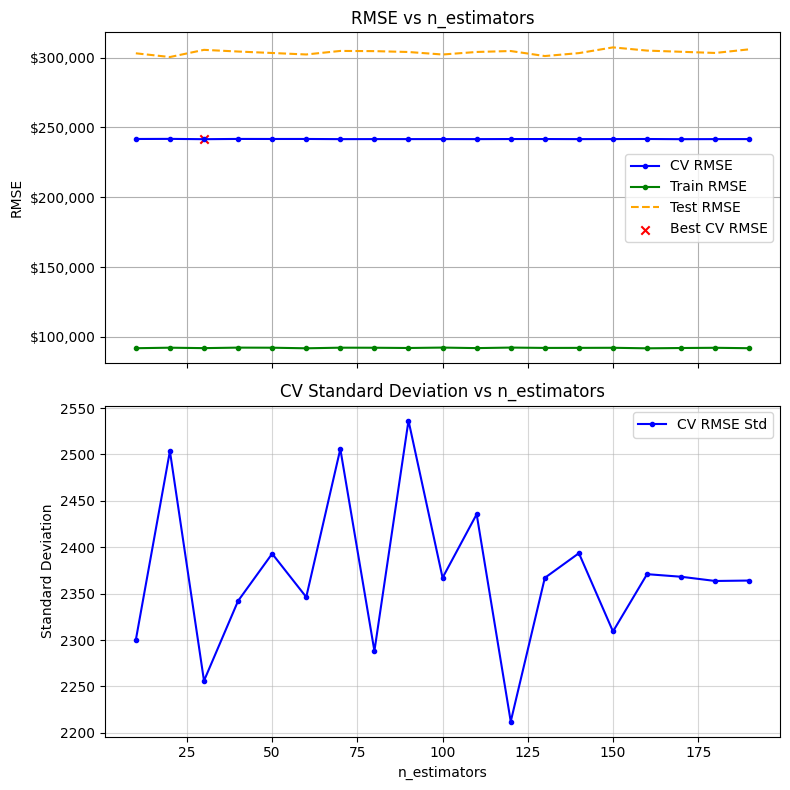

Execution Time: 00:57:42


In [ ]:
# Sweep n_estimators for random forest
rf_parameters = {}
rf_first_sweep = sweep_parameter(RandomForestRegressor(), Default_Parameters_Random_Forests, 'n_estimators', range(10, 200, 10))
rf_parameters['n_estimatosrs'] = rf_first_sweep['n_estimators']

Sweeping max_features: 100%|██████████| 10/10 [31:55<00:00, 191.55s/it]


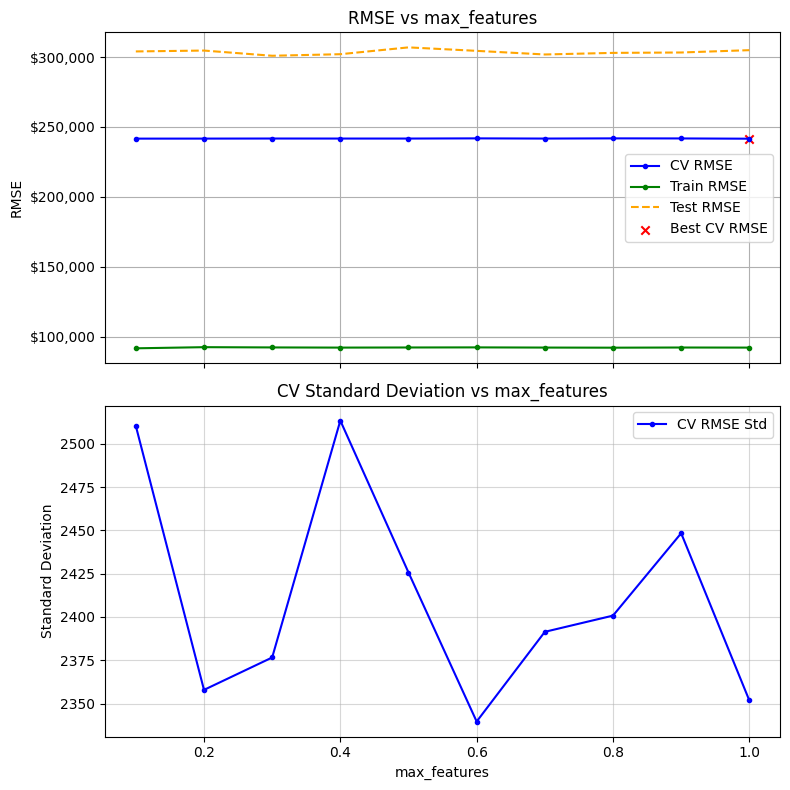

Execution Time: 00:31:55


In [62]:
# Sweep max features from random forest
rf_second_sweep = sweep_parameter(RandomForestRegressor(), Default_Parameters_Random_Forests, 'max_features', np.linspace(0.1, 1.0, 10))
rf_parameters['max_features'] = rf_second_sweep['max_features']

Sweeping max_depth: 100%|██████████| 17/17 [51:19<00:00, 181.13s/it]


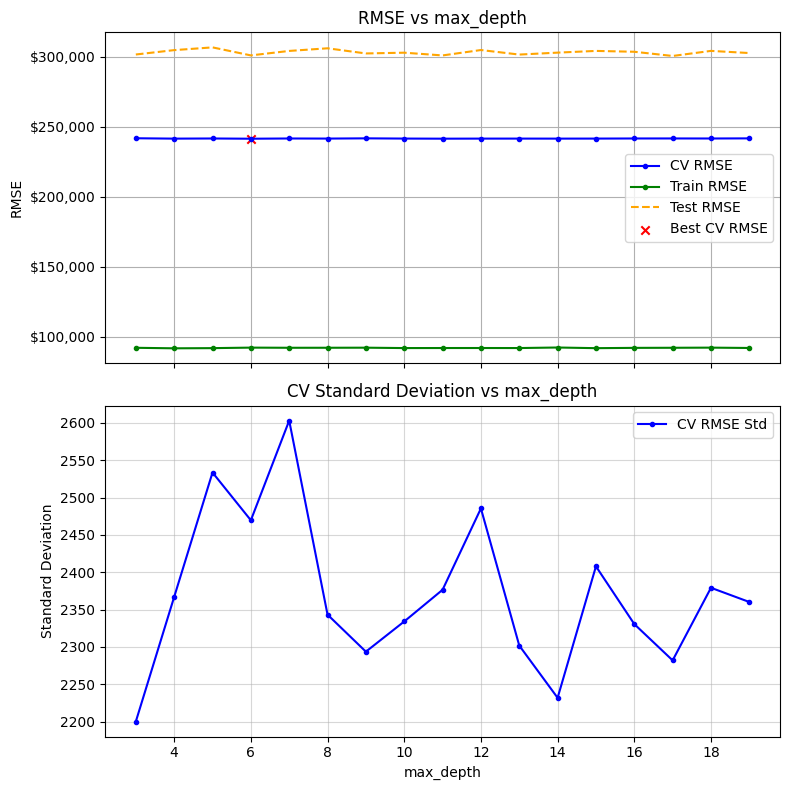

Execution Time: 00:51:19


In [ ]:
# Sweep max depth from random forest
rf_third_sweep = sweep_parameter(RandomForestRegressor(), Default_Parameters_Random_Forests, 'max_depth', range(3,20,1))
rf_parameters['max_depth'] = rf_third_sweep['max_depth']

Sweeping min_samples_split: 100%|██████████| 8/8 [22:14<00:00, 166.78s/it]


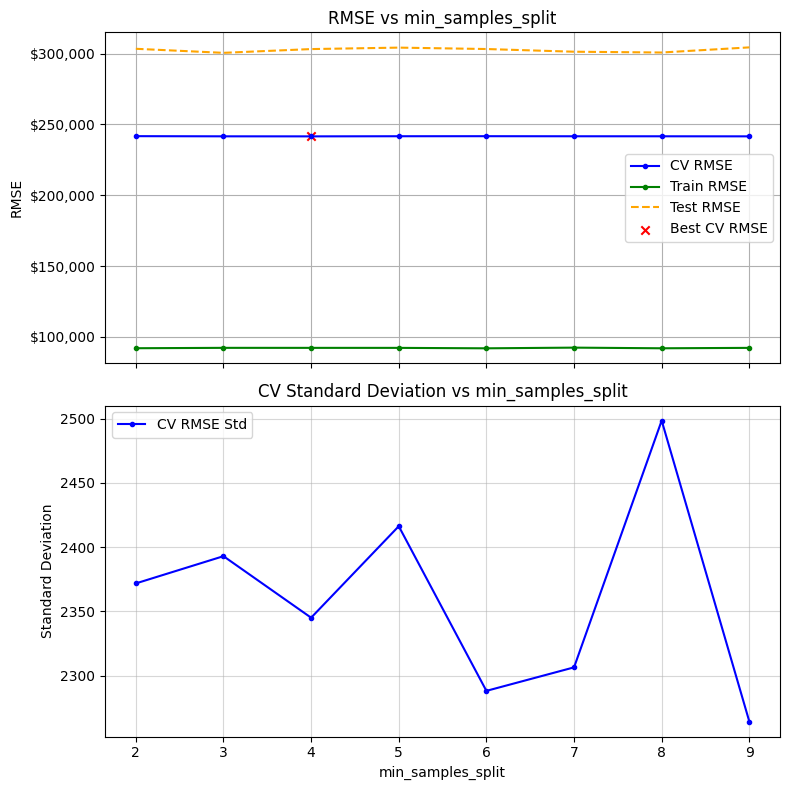

Execution Time: 00:22:14


In [ ]:
# Sweep min samples split from random forest
rf_fourth_sweep = sweep_parameter(RandomForestRegressor(), Default_Parameters_Random_Forests, 'min_samples_split', range(2,8,1))
rf_parameters['min_samples_split'] = rf_fourth_sweep['min_samples_split']

Sweeping learning_rate: 100%|██████████| 10/10 [05:24<00:00, 32.41s/it]


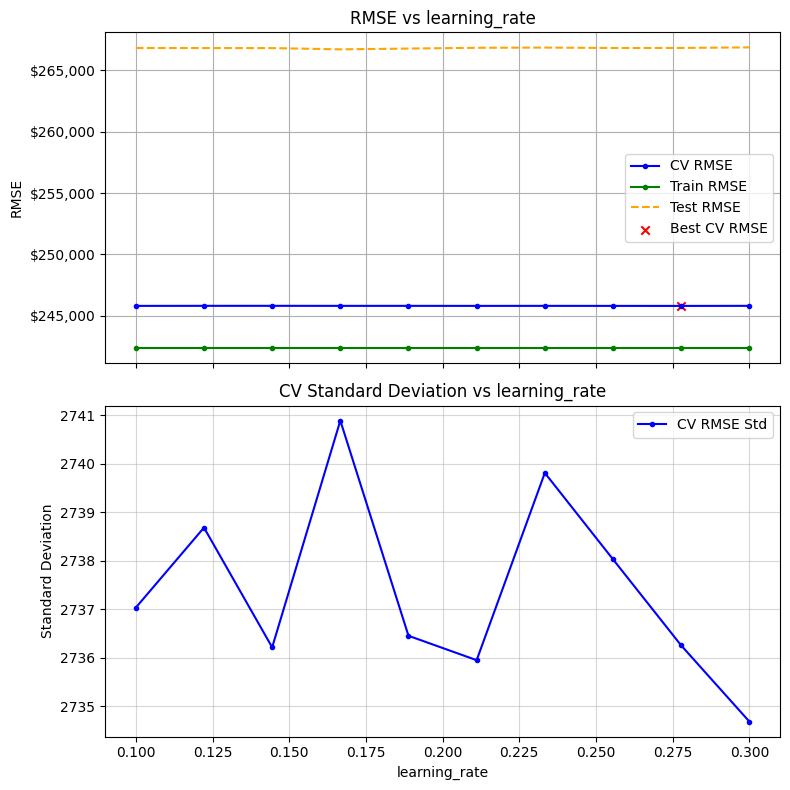

Execution Time: 00:05:24


In [66]:
# Sweep the learning rate from gradient boosting
gb_parameters = {}
gb_first_sweep = sweep_parameter(GradientBoostingRegressor(), Default_Parameters_GradientBoosting, 'learning_rate', np.linspace(0.1, 0.3, 10))
gb_parameters['learning_rate'] = gb_first_sweep['learning_rate']

Sweeping n_estimators: 100%|██████████| 19/19 [10:05<00:00, 31.87s/it]


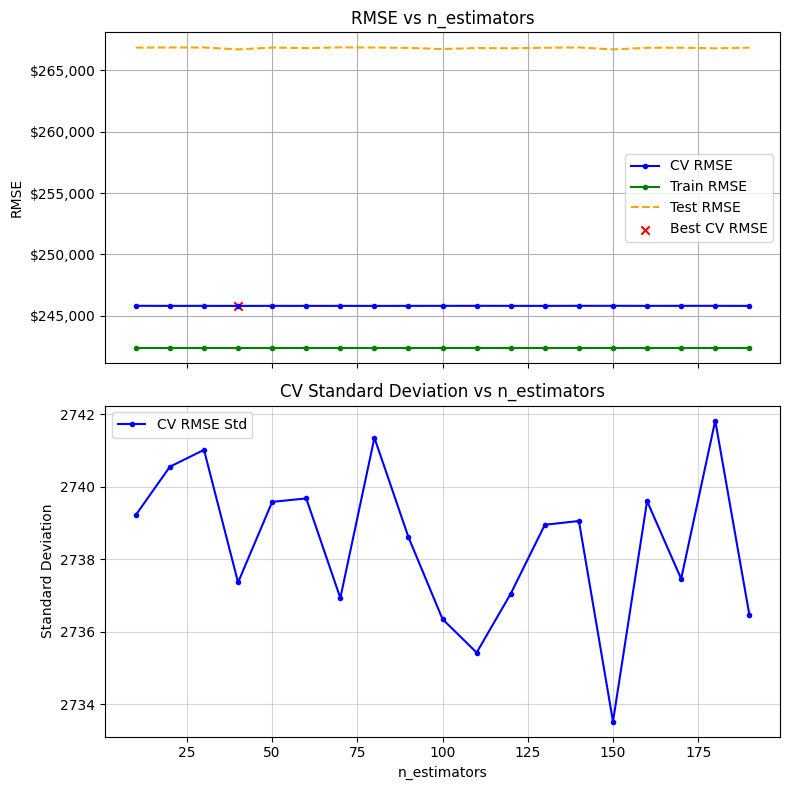

Execution Time: 00:10:05


In [ ]:
# Sweep n_estimators from gradient boosting
gb_second_sweep = sweep_parameter(GradientBoostingRegressor(), Default_Parameters_GradientBoosting, 'n_estimators', range(10, 200, 10))
gb_parameters['n_estimators'] = gb_second_sweep['n_estimators']

Sweeping max_depth: 100%|██████████| 17/17 [08:52<00:00, 31.32s/it]


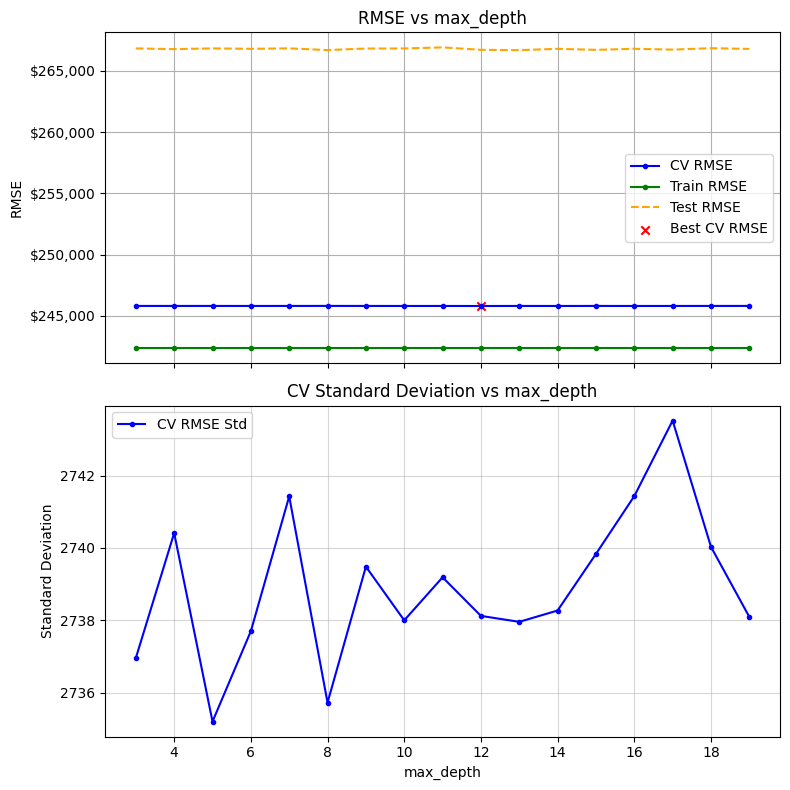

Execution Time: 00:08:52


In [68]:
# Sweep max depth from gradient boosting
gb_third_sweep = sweep_parameter(GradientBoostingRegressor(), Default_Parameters_GradientBoosting, 'max_depth', range(3, 20, 1))
gb_parameters['max_depth'] = gb_third_sweep['max_depth']

Sweeping max_features: 100%|██████████| 10/10 [05:08<00:00, 30.85s/it]


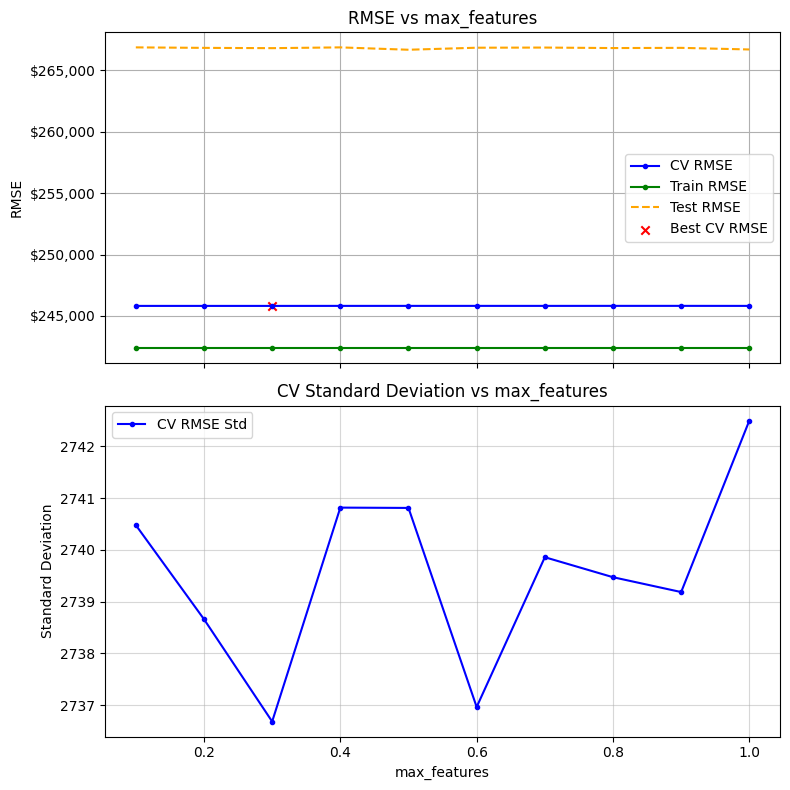

Execution Time: 00:05:08


In [69]:
# Sweep max features from gradient boosting
gb_fourth_sweep = sweep_parameter(GradientBoostingRegressor(), Default_Parameters_GradientBoosting, 'max_features', np.linspace(0.1, 1.0, 10))
gb_parameters['max_features'] = gb_fourth_sweep['max_features']

In [70]:
# Remove unnecessary records from dictionaries
rf_parameters.pop('RMSE_found', None)
gb_parameters.pop('RMSE_found', None)

print("Random Forest Parameters:")
print(rf_parameters)
print("============================")
print("Gradient Boosting Parameters:")
print(gb_parameters)

Random Forest Parameters:
{'n_estimatosrs': 30, 'max_features': np.float64(1.0), 'max_depth': 6, 'min_samples_split': 4}
Gradient Boosting Parameters:
{'learning_rate': np.float64(0.2777777777777778), 'n_estimators': 40, 'max_depth': 12, 'max_features': np.float64(0.30000000000000004)}


In [71]:
# Evaluate the Random Forest model with the best parameters
rf_evaluation = evaluate_model({"Random Forest": RandomForestRegressor()}, 
                               X_train_scaled, y_train, X_test_scaled, y_test, evaluate=True, **rf_parameters)
gb_evaluation = evaluate_model({'Gradient Boosting': GradientBoostingRegressor()}, 
                               X_train_scaled, y_train, X_test_scaled, y_test, evaluate=True, **gb_parameters)

Evaluating Random Forest…
Evaluating Gradient Boosting…


In [ ]:
# Print Final Results
final = pd.concat([rf_evaluation, gb_evaluation]).sort_values(by='Test CV RMSE', ascending=True)
final

,Mean CV RMSE,STD CV RMSE,Train CV RMSE,Test CV RMSE
Model,,,,
Gradient Boosting,"$245,813","$2,735","$242,356","$266,873"
Random Forest,"$241,666","$2,433","$92,200","$301,367"


### Part 4: Discussion [4 pts]

Reflect on your tuning process and final results:

- What was your tuning strategy for each model? Why did you choose those hyperparameters?
- Did you find that certain types of preprocessing or feature engineering worked better with specific models?
- Provide a ranking of your three models and explain your reasoning — not just based on RMSE, but also interpretability, training time, or generalizability.
- Conclude by considering whether this workflow has produced the results you expected. Typically, you would repeat steps 2 - 4 and also reconsider the choices you made in Milestone 1 when cleaning the dataset, until reaching the point of diminishing returns; do you think that would that have helped here?

> Your text here